In [1]:
import os
import tqdm
import string
import random
import numpy as np
import pandas as pd
from collections import *
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score

In [2]:
### READ DATA ###

df = pd.read_csv('Uber_Ride_Reviews.csv')

print(df.shape)
df.head()

(1344, 3)


,ride_review,ride_rating,sentiment
0,I completed running New York Marathon requeste...,1.0,0
1,My appointment time auto repairs required earl...,1.0,0
2,Whether I using Uber ride service Uber Eats or...,1.0,0
3,Why hard understand I trying retrieve Uber cab...,1.0,0
4,I South Beach FL I staying major hotel ordered...,1.0,0


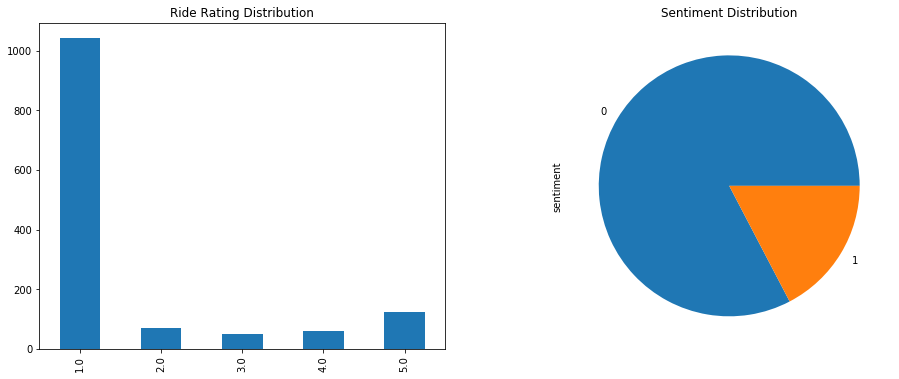

In [3]:
### LABEL DISTRIBUTION ###

plt.figure(figsize=(16,6))

plt.subplot(121)
df.ride_rating.value_counts().sort_index().plot.bar(title='Ride Rating Distribution')

plt.subplot(122)
df.sentiment.value_counts().plot.pie(title='Sentiment Distribution')

In [4]:
### REMOVE 3 STARS REVIEWS ###

df = df.loc[df.ride_rating!=3, :].reset_index(drop=True)

In [5]:
### CLEAN TEXT (NOT REQUIRED) ###

df['text'] = df.ride_review.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ', regex=True)

In [6]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['sentiment'].values, 
                                                    random_state = 42, test_size=0.2)

In [7]:
### CREATE FEATURES WITH TFIDF ###

stop = set(stopwords.words('english'))
tfidf = TfidfVectorizer(min_df=3, stop_words=stop)
tfidf.fit(X_train)

TfidfVectorizer(min_df=3,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [8]:
### REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

c = Counter([len(s.split()) for s in X_train])
lenghts = np.asarray(list(c.keys()))
freq = np.asarray(list(c.values()))
freq = freq/freq.sum()

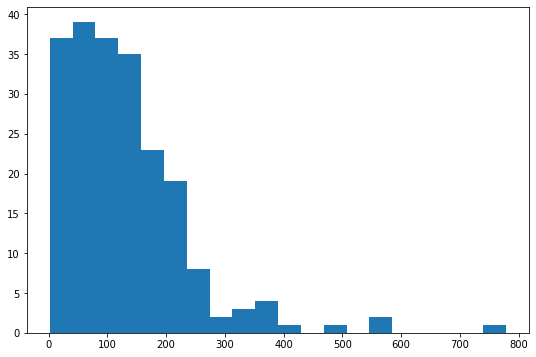

In [9]:
### PLOT REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

plt.figure(figsize=(9,6))
plt.hist(lenghts, bins=20)
np.set_printoptions(False)

In [10]:
### DEFINE MARKOV CHAIN GENERATOR ###

def build_chain(texts):
    
    index = 1
    chain = {}
    
    for text in texts:
        
        text = text.split()
        for word in text[index:]:
            key = text[index-1]
            if key in chain:
                chain[key].append(word)
            else:
                chain[key] = [word]
            index += 1
        
        index = 1
    
    return chain

def create_sentence(chain, lenght, seed):
        
    start = random.choice(list(chain.keys()))
    text = [start]

    while len(text) < lenght:
        try:
            after = random.choice(chain[start])
            start = after
            text.append(after)
        except: #end of the sentence
            #text.append('.')
            start = random.choice(list(chain.keys()))
    
    return ' '.join(text)

def Generator(x_train, y_train, rep, concat=False, seed=33):
    
    random.seed(seed)
    np.random.seed(seed)
    
    new_corpus, new_labels = [], []
    
    for i,lab in enumerate(np.unique(y_train)):

        selected = x_train[y_train == lab]
        chain = build_chain(selected)

        sentences = []
        for i in range(rep):
            lenght = int(np.random.choice(lenghts, 1, p=freq))
            sentences.append(create_sentence(chain, lenght, seed))

        new_corpus.extend(sentences)
        new_labels.extend([lab]*rep)
    
    if concat:
        return np.asarray(list(x_train) + new_corpus), np.asarray(list(y_train) + new_labels)
    
    return np.asarray(new_corpus), np.asarray(new_labels)

In [11]:
### AUGMENT TRAIN DATA ###

X_train_new, y_train_new = Generator(X_train, y_train, rep=300, concat=True, seed=33)

In [12]:
pd.value_counts(y_train_new)

0    1195
1     440
dtype: int64

In [13]:
### CREATE FAKE TEST DATA ###

X_test_new, y_test_new = Generator(X_train, y_train, rep=100, concat=False, seed=42)

In [14]:
pd.value_counts(y_test_new)

0    100
1    100
dtype: int64

In [15]:
### PERFORMANCE REPORT ###

def report_performances(model, y_test, x_test):
    
    performance = {}
    x_test = tfidf.transform(x_test)
    
    performance['auc'] = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    performance['precision'] = precision_score(y_test, model.predict(x_test), average='macro')
    performance['recall'] = recall_score(y_test, model.predict(x_test), average='macro')
    performance['f1'] = f1_score(y_test, model.predict(x_test), average='macro')
    
    return performance

# FIT ON ORIGINAL DATA

In [16]:
nn = GridSearchCV(
    MLPClassifier(random_state=42), cv=3, n_jobs=-1,
    param_grid={'hidden_layer_sizes': [(256, 128, 64), (256, 128), (256,)]}
)
nn.fit(tfidf.transform(X_train), y_train)

nn.best_params_

{'hidden_layer_sizes': (256, 128, 64)}

In [17]:
nn_train = report_performances(nn, y_test, X_test)

In [18]:
nn_train_new = report_performances(nn, y_test_new, X_test_new)

In [19]:
logistic = GridSearchCV(
    LogisticRegression(random_state=42), cv=3, n_jobs=-1,
    param_grid={'solver': ['liblinear', 'lbfgs'],
                'C': [0.01, 1, 10]}
)
logistic.fit(tfidf.transform(X_train), y_train)

logistic.best_params_

{'C': 10, 'solver': 'liblinear'}

In [20]:
logistic_train = report_performances(logistic, y_test, X_test)

In [21]:
logistic_train_new = report_performances(logistic, y_test_new, X_test_new)

In [22]:
rf = GridSearchCV(
    RandomForestClassifier(random_state=42), cv=3, n_jobs=-1,
    param_grid={'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20]}
)
rf.fit(tfidf.transform(X_train), y_train)

rf.best_params_

{'max_depth': None, 'n_estimators': 100}

In [23]:
rf_train = report_performances(rf, y_test, X_test)

In [24]:
rf_train_new = report_performances(rf, y_test_new, X_test_new)

# FIT ON ORIGINAL + GENERATED DATA

In [25]:
nn = GridSearchCV(
    MLPClassifier(random_state=42), cv=3, n_jobs=-1,
    param_grid={'hidden_layer_sizes': [(256, 128, 64), (256, 128), (256,)]}
)
nn.fit(tfidf.transform(X_train_new), y_train_new)

nn.best_params_

{'hidden_layer_sizes': (256, 128, 64)}

In [26]:
nn_train_aug = report_performances(nn, y_test, X_test)

In [27]:
nn_train_aug_new = report_performances(nn, y_test_new, X_test_new)

In [28]:
logistic = GridSearchCV(
    LogisticRegression(random_state=42), cv=3, n_jobs=-1,
    param_grid={'solver': ['liblinear', 'lbfgs'],
                'C': [0.01, 1, 10]}
)
logistic.fit(tfidf.transform(X_train_new), y_train_new)

logistic.best_params_

{'C': 10, 'solver': 'lbfgs'}

In [29]:
logistic_train_aug = report_performances(logistic, y_test, X_test)

In [30]:
logistic_train_aug_new = report_performances(logistic, y_test_new, X_test_new)

In [31]:
rf = GridSearchCV(
    RandomForestClassifier(random_state=42), cv=3, n_jobs=-1,
    param_grid={'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20]}
)
rf.fit(tfidf.transform(X_train_new), y_train_new)

rf.best_params_

{'max_depth': None, 'n_estimators': 200}

In [32]:
rf_train_aug = report_performances(rf, y_test, X_test)

In [33]:
rf_train_aug_new = report_performances(rf, y_test_new, X_test_new)

# PERFORMANCE COMPARISON

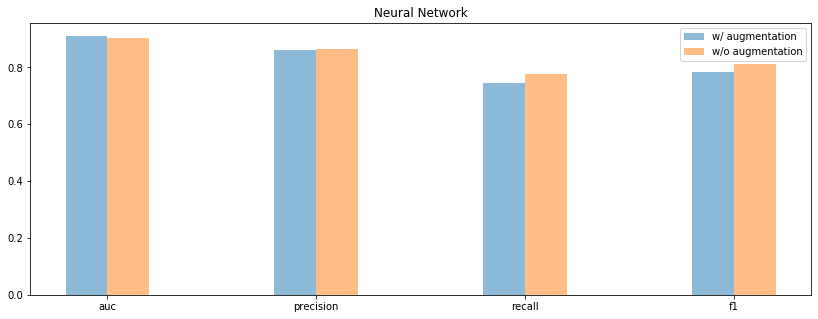

In [34]:
### PERFORMANCE ON THE STANDARD TEST ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(nn_train_aug))-0.1, nn_train_aug.values(), 
        alpha=0.5, width=0.2, label='w/ augmentation')
plt.bar(np.arange(len(nn_train))+0.1, nn_train.values(), 
        alpha=0.5, width=0.2, label='w/o augmentation')
plt.xticks(range(len(nn_train_aug)), nn_train_aug.keys())
plt.title('Neural Network'); plt.legend()
plt.show()

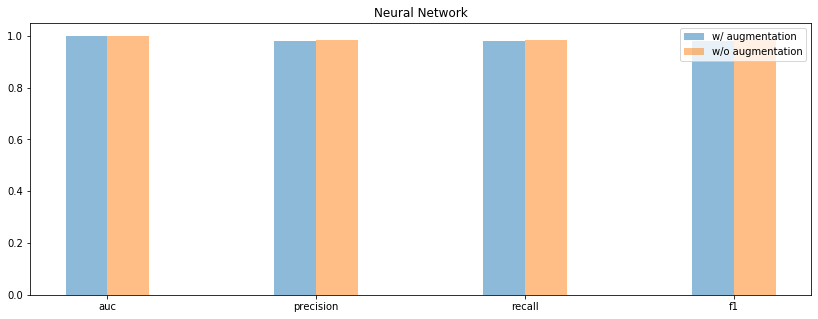

In [35]:
### PERFORMANCE ON THE FAKE TEST ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(nn_train_aug_new))-0.1, nn_train_aug_new.values(), 
        alpha=0.5, width=0.2, label='w/ augmentation')
plt.bar(np.arange(len(nn_train_new))+0.1, nn_train_new.values(), 
        alpha=0.5, width=0.2, label='w/o augmentation')
plt.xticks(range(len(nn_train_aug_new)), nn_train_aug_new.keys())
plt.title('Neural Network'); plt.legend()
plt.show()

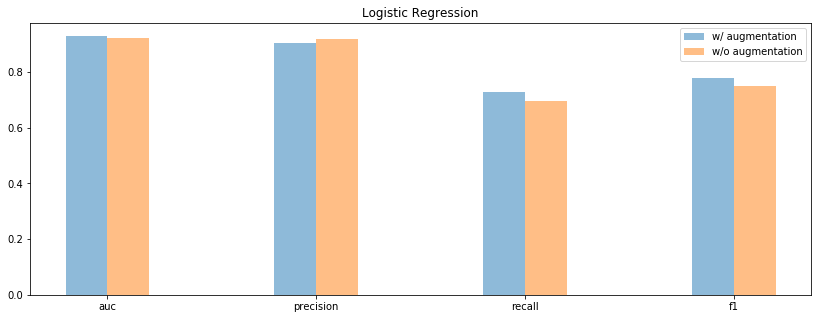

In [36]:
### PERFORMANCE ON THE STANDARD TEST ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(logistic_train_aug))-0.1, logistic_train_aug.values(), 
        alpha=0.5, width=0.2, label='w/ augmentation')
plt.bar(np.arange(len(logistic_train))+0.1, logistic_train.values(), 
        alpha=0.5, width=0.2, label='w/o augmentation')
plt.xticks(range(len(logistic_train_aug)), logistic_train_aug.keys())
plt.title('Logistic Regression'); plt.legend()
plt.show()

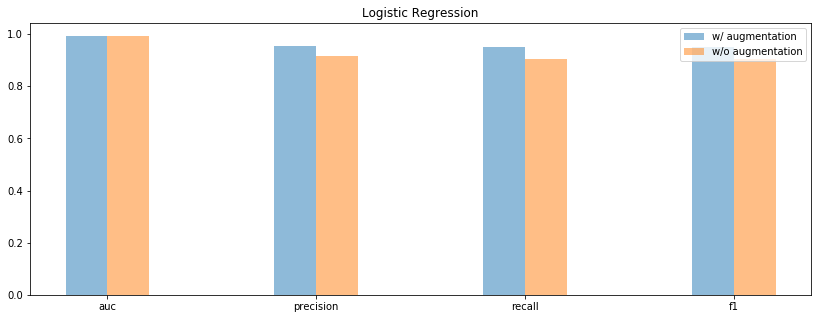

In [37]:
### PERFORMANCE ON THE FAKE TEST ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(logistic_train_aug_new))-0.1, logistic_train_aug_new.values(), 
        alpha=0.5, width=0.2, label='w/ augmentation')
plt.bar(np.arange(len(logistic_train_aug_new))+0.1, logistic_train_new.values(), 
        alpha=0.5, width=0.2, label='w/o augmentation')
plt.xticks(range(len(logistic_train_aug_new)), logistic_train_aug_new.keys())
plt.title('Logistic Regression'); plt.legend()
plt.show()

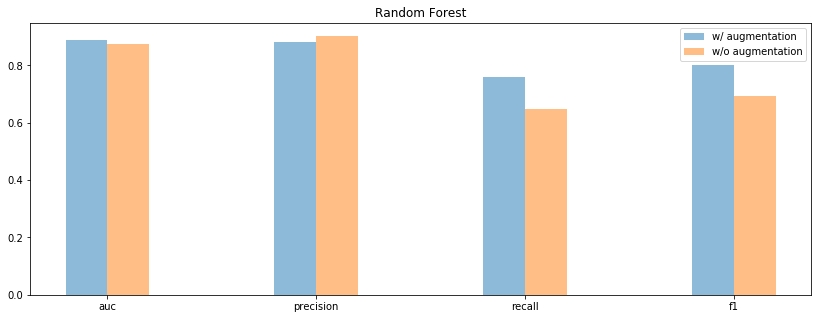

In [38]:
### PERFORMANCE ON THE STANDARD TEST ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(rf_train_aug))-0.1, rf_train_aug.values(), 
        alpha=0.5, width=0.2, label='w/ augmentation')
plt.bar(np.arange(len(rf_train))+0.1, rf_train.values(), 
        alpha=0.5, width=0.2, label='w/o augmentation')
plt.xticks(range(len(rf_train_aug)), rf_train_aug.keys())
plt.title('Random Forest'); plt.legend()
plt.show()

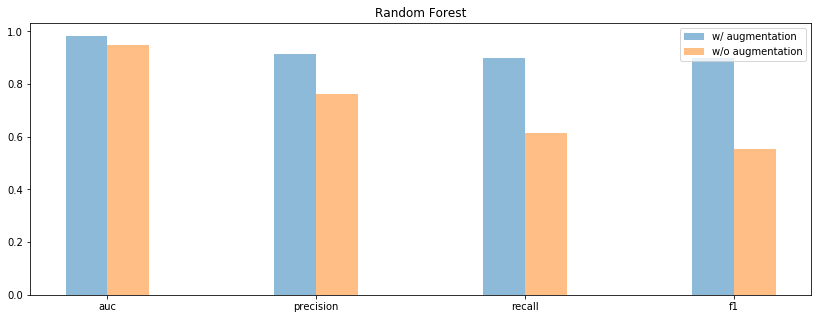

In [39]:
### PERFORMANCE ON THE FAKE TEST ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(rf_train_aug_new))-0.1, rf_train_aug_new.values(), 
        alpha=0.5, width=0.2, label='w/ augmentation')
plt.bar(np.arange(len(rf_train_new))+0.1, rf_train_new.values(), 
        alpha=0.5, width=0.2, label='w/o augmentation')
plt.xticks(range(len(rf_train_aug_new)), rf_train_aug_new.keys())
plt.title('Random Forest'); plt.legend()
plt.show()